In [25]:
import os
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import joblib
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
import scipy

In [26]:
filepath = 'C:/Users/zlj01/Documents/Columbia University/GR5243/project 3/'
os.chdir(filepath)

trainpath = filepath + '/data/train_set/'

train_image_dir = trainpath + "images/"
train_pt_dir = trainpath + "points/"

In [27]:
import sklearn.metrics.pairwise
def pairwise_dist(vec):
    dist  = sklearn.metrics.pairwise_distances(vec, metric='euclidean')
    np.fill_diagonal(dist, np.nan)
    return dist
def feature(fiducial_pt_list,index):
    pairwise_dist_feature = pairwise_dist(fiducial_pt_list[index]).flatten()
    pairwise_dist_feature = pairwise_dist_feature[~np.isnan(pairwise_dist_feature)]
    return pairwise_dist_feature

f0 = time.time()
dataDir = train_pt_dir
fiducial_pt_list = []
filelist = []
for file in os.listdir(dataDir):
    filelist.append(file)
filelist.sort()
for file in filelist:
    fiducial_pt_list.append(scipy.io.loadmat(dataDir+file))
    l = []
for i in range(len(fiducial_pt_list)):
    if 'faceCoordinatesUnwarped' in fiducial_pt_list[i].keys():
        l.append(fiducial_pt_list[i]['faceCoordinatesUnwarped'])
    else:
        l.append(fiducial_pt_list[i]['faceCoordinates2'])
        
fiducial_pt_list = l

## Train / Test dataset split

In [28]:
X = pd.DataFrame(np.zeros((3000, 6006)))
for i in range(3000):
    X.iloc[i,:] = np.round(feature(fiducial_pt_list, i).flatten(), 0)
y =pd.read_csv(trainpath+'label.csv')['label']
f1 = time.time()-f0

train_x_dis,test_x_dis,train_y_dis,test_y_dis=train_test_split(X,y,test_size=0.2,random_state=123)
X_dis=X
y_dis=y

## Feature Scaling

In [29]:
sc = StandardScaler()

# Set the standard scaler by using the train set
train_x_dis = sc.fit_transform(train_x_dis)

# scale the testset based on the standard scaler of the train set
test_x_dis = sc.transform(test_x_dis)

## Deal with imbalance data

In [30]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where

# summarize class distribution
counter = Counter(train_y_dis)
print(counter)



Counter({0: 1916, 1: 484})


### Oversampling using SMOTE

In [31]:
# transform the train dataset
oversample = SMOTE()
train_x_dis, train_y_dis = oversample.fit_resample(train_x_dis, train_y_dis)

# summarize the new class distribution
counter = Counter(train_y_dis)
print(counter)

Counter({1: 1916, 0: 1916})


## GridsearchCV to do hyperparameter tuning in the XGBoost

In [35]:
from sklearn.model_selection import GridSearchCV
xgboost_parm_gs = {
    'max_depth':[2,4,8] ,
    'n_estimator': [50,100],
    'learning_rate': [0.1,0.05,0.01]
}
xgboost_model_gs = xgboost.XGBClassifier()
xgboost_gsearch = GridSearchCV(estimator = xgboost_model_gs, 
                               param_grid = xgboost_parm_gs, 
                               scoring ='accuracy',
                               n_jobs = 8,
                               verbose=3,
                               return_train_score=True
                              )
xgboost_gsearch.fit(train_x_dis,train_y_dis)
print(xgboost_gsearch.best_estimator_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done  90 out of  90 | elapsed: 24.4min finished


[10:10:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimator=50, n_estimators=100, n_jobs=0, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)


In [36]:
from sklearn.metrics import accuracy_score
print("Training dataset Accuracy")
train_preds = xgboost_gsearch.predict(train_x_dis)
train_accuracy = accuracy_score(train_y_dis, train_preds) 
print(train_accuracy)

Training dataset Accuracy
1.0


In [37]:
print("Testing dataset Accuracy")
test_preds = xgboost_gsearch.predict(test_x_dis)
test_accuracy = accuracy_score(test_y_dis, test_preds) 
print(test_accuracy)

Testing dataset Accuracy
0.8483333333333334


## ROC Curve with AUC

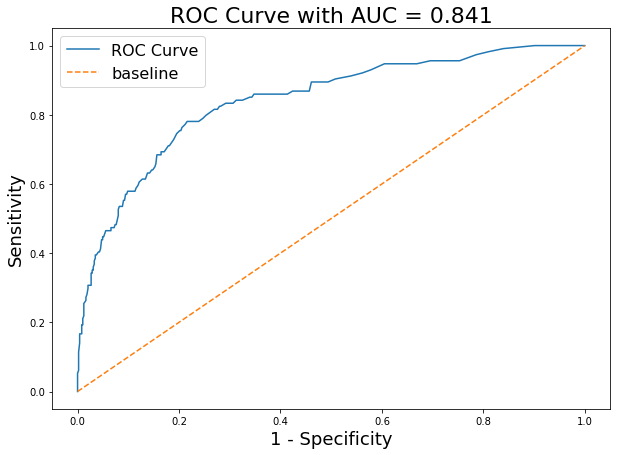

In [41]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve


# Calculating class probabilities
pred_proba = [i[1] for i in xgboost_gsearch.predict_proba(test_x_dis)]
pred_df = pd.DataFrame({'true_values': test_y_dis,
                        'pred_probs':pred_proba})

# The codes below is motly copied from the code written by Matt Brem, Global Instructor at General Assembly.
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. 
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f"ROC Curve with AUC = {round(metrics.roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),3)}", fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);